# Forecasting

In this notebook we train our models to perform and evaluate bixi usage forecasts.

Model tuning and performance assesment is done using a validation set. For most models, this is accomplished via a cross-validation procedure using a seasonal time-series split on the training data.

For a few of the models, we use a fixed time-split for validation due to it being a requirement of the tool/framework we were using, however we still provide historical forecast performance metric.

After the tuning is complete, we evaluate final model performance by performing a forecast on the held-out test data.

Required imports:

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Utilities for data loading and validation
from lib import utils
from lib.utils import cv_predict
from lib.utils import evaluate
from lib.utils import plot_and_evaluate

# Imports required for particular models are done in their respective sections

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>
<div style="border-bottom: 3px solid black"></div>

### Load the Data

Load the Mont-Royal trip history data.

In [2]:
station_bike_demand = utils.load_station_data('data/mr_bike_demand.csv')
display(station_bike_demand)

,trip_count
2014-01-01,0
2014-01-02,0
2014-01-03,0
2014-01-04,0
2014-01-05,0
...,...
2019-12-27,0
2019-12-28,0
2019-12-29,0
2019-12-30,0


### Split the Data

Split the data into training and test sets.
* Training set: from 2014 to 2018 (inclusive)
* Test set: 2019

Since the main low-frequency data periodicity is yearly, it makes sense to do a yearly split. This split gives approximately a 5 to 1 training to test split ratio (about 83:17).

**Notes**: 
* 2020 was excluded due to overall trend dip because of the pandemic, as can be seen in the visualization notebook.
* 2019 is missing the data for November so using it as test data will lead to large errors for November. We might want to exlude November from the test error calculations,

In [3]:
# Split station data into training and test set
demand_train = station_bike_demand['2014':'2018']
demand_test  = station_bike_demand['2019':'2019']

Define common constants used throughout all models:

In [4]:
# Define validation and test parameters

# Configure the seasonal period to be yearly
seasonal_period = 365
# Configure test forecasting horizon
test_fh = np.arange(1, 366)

# Create a DataFrame for storing historical forecast and test performance of each model
validation_scores = dict()
test_scores = dict()

# Dummy Baselines

## Seasonal Naive Baseline 

We will use Seasonal Naive model from the **sktime** library as our dummy baseline in two configurations:
* *last* - use the last year data as the prediction for the next.
* *mean* - use the mean data of all previous years as the prediction for the next.

Imports:

In [5]:
from sktime.forecasting.naive import NaiveForecaster

### Cross Validation

Use time-series split to perform cross-validation and see how the naive baseline performs.

Error metrics for Naive Last Seasonal Forecaster (HF):

RMSE: 44.1642
MAE: 25.7068


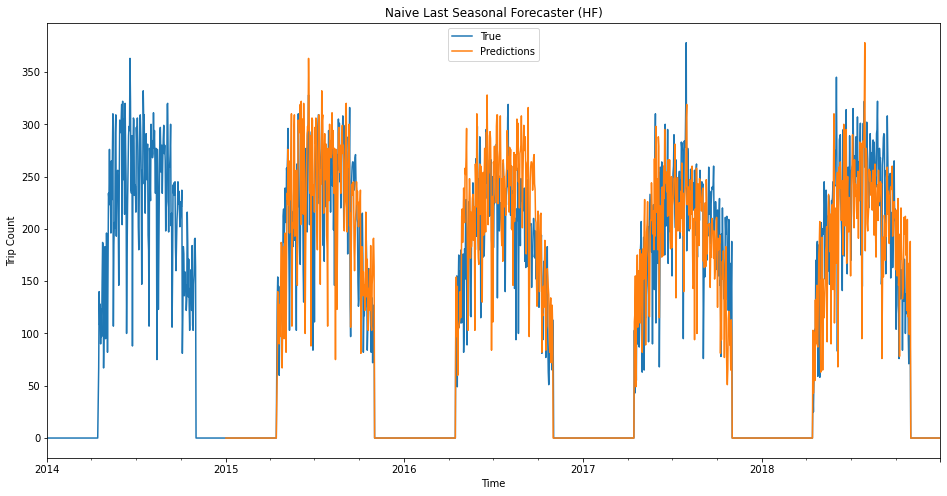

In [6]:
# Perform CV using the last strategy
forecaster = NaiveForecaster(strategy="last", sp = seasonal_period)
results = cv_predict(forecaster, demand_train, seasonal_period)
predictions = utils.merge_cv_predictions(results)

utils.plot_and_evaluate(demand_train, predictions, title='Naive Last Seasonal Forecaster (HF)');

Error metrics for Naive Mean Seasonal Forecaster (HF):

RMSE: 40.8267
MAE: 23.4603


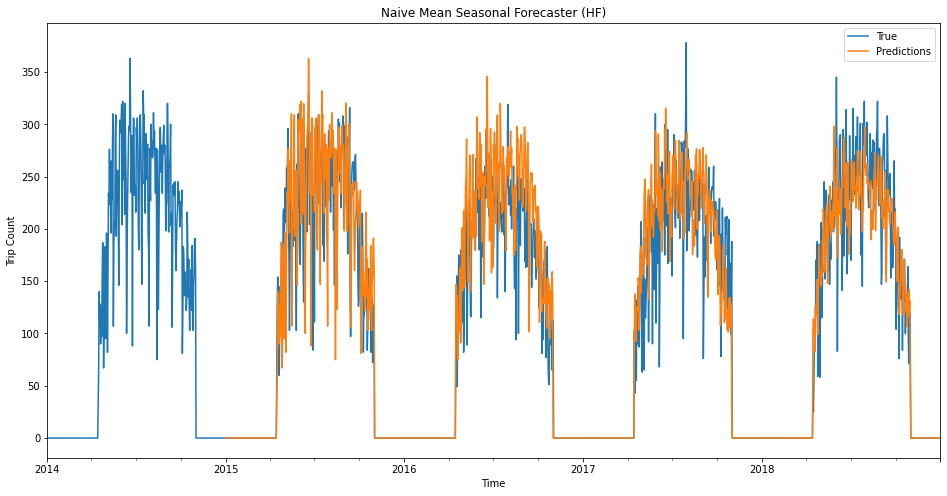

In [7]:
# Perform CV using the mean strategy
forecaster = NaiveForecaster(strategy="mean", sp = seasonal_period)
results = cv_predict(forecaster, demand_train, seasonal_period)
predictions = utils.merge_cv_predictions(results)

plot_and_evaluate(demand_train, predictions, title='Naive Mean Seasonal Forecaster (HF)');

# Save best scores
validation_scores['naive'] = evaluate(demand_train, predictions)

### Test Performance

Error metrics for Naive Last Seasonal Forecaster (Test):

RMSE: 41.4485
MAE: 23.8767


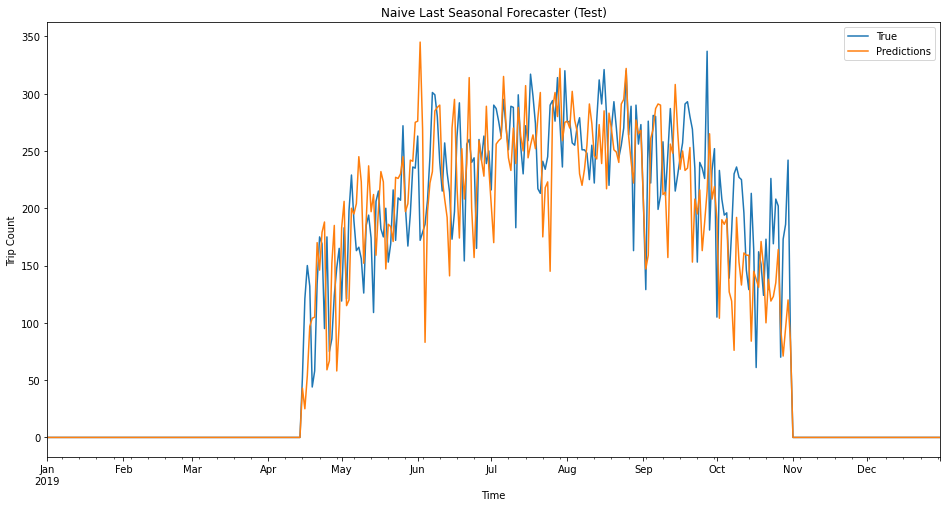

In [8]:
# Forecast using the seasonal naive random walk forecast
forecaster = NaiveForecaster(strategy="last", sp = seasonal_period) 
forecaster.fit(demand_train)

predictions = forecaster.predict(test_fh)

plot_and_evaluate(demand_test, predictions, title='Naive Last Seasonal Forecaster (Test)');

Error metrics for Naive Mean Seasonal Forecaster (Test):

RMSE: 37.0497
MAE: 22.2521


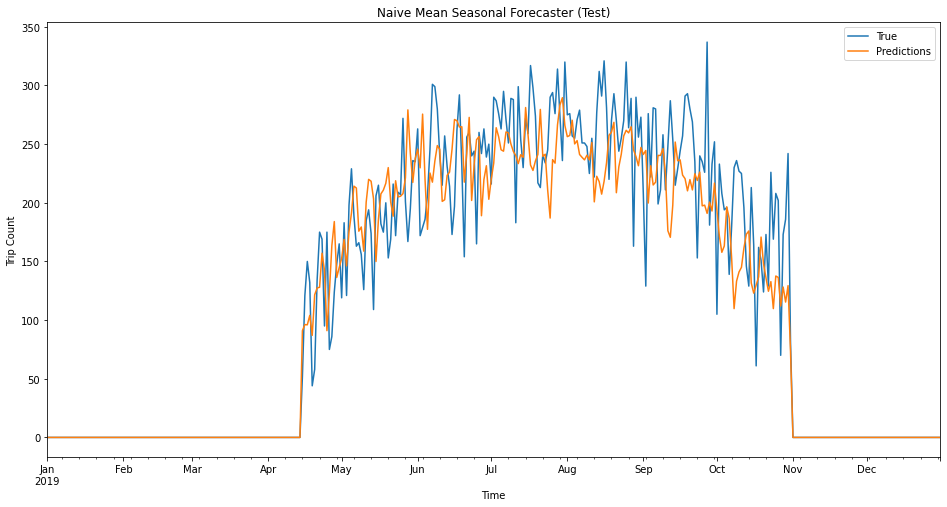

In [9]:
# Forecast using the seasonal naive mean forecast
forecaster = NaiveForecaster(strategy="mean", sp = seasonal_period) 
forecaster.fit(demand_train)

# Predict and plot
predictions = forecaster.predict(test_fh)
plot_and_evaluate(demand_test, predictions, title='Naive Mean Seasonal Forecaster (Test)');

# Save test score
test_scores['naive'] = evaluate(demand_test, predictions)

# Facebook Prophet

Basic Facebook Prophet baseline.

**Note**: needs some tuning to perform well.

Required imports:

In [10]:
from sktime.forecasting.fbprophet import Prophet

### Cross Validation

In [11]:
# Configure the model
forecaster = Prophet(
    seasonality_mode='additive',
    n_changepoints=8,
    add_country_holidays={'country_name': 'Canada'},
    daily_seasonality=False,
    yearly_seasonality=True)

Error metrics for Facebook Prophet (HF):

RMSE: 33.8148
MAE: 18.9721


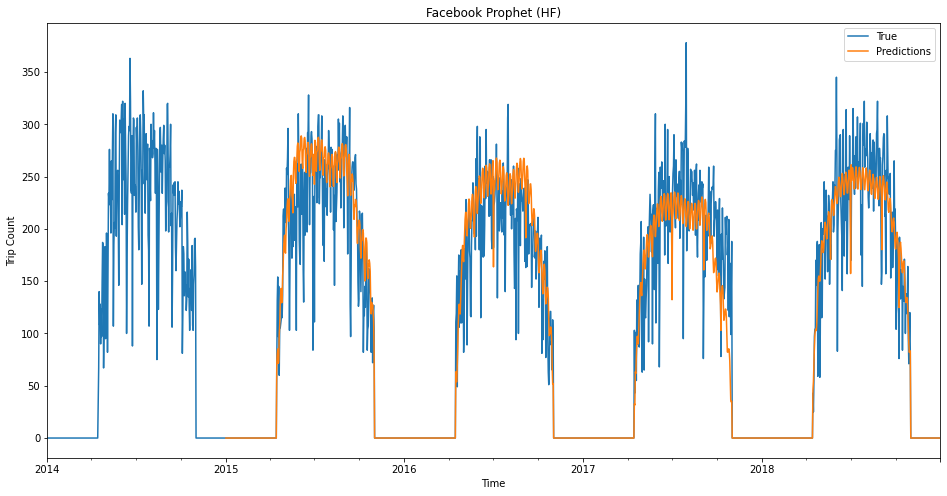

In [12]:
results = cv_predict(forecaster, demand_train['trip_count'], seasonal_period)
predictions = utils.merge_cv_predictions(results).to_frame(name='trip_count')

plot_and_evaluate(demand_train, predictions, title='Facebook Prophet (HF)');

# Save score
validation_scores['prophet'] = evaluate(demand_train, predictions)

### Test Performance

In [13]:
# Configure the model
forecaster = Prophet(
    seasonality_mode='additive',
    n_changepoints=8,
    add_country_holidays={'country_name': 'Canada'},
    daily_seasonality=False,
    yearly_seasonality=True)

# Train the model
forecaster.fit(demand_train['trip_count'])

Prophet(add_country_holidays={'country_name': 'Canada'},
        daily_seasonality=False, n_changepoints=8, yearly_seasonality=True)

Error metrics for Facebook Prophet (Test):

RMSE: 31.2242
MAE: 18.2348


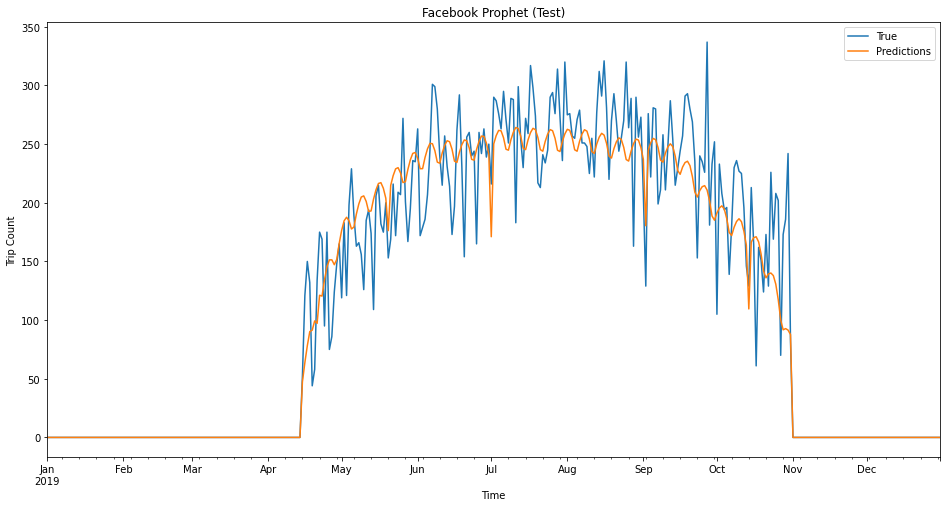

In [14]:
# Get predictions
predictions = forecaster.predict(test_fh).to_frame(name='trip_count')
# Evaluate and plot the forecast
plot_and_evaluate(demand_test, predictions, title='Facebook Prophet (Test)');

# Save score
test_scores['prophet'] = evaluate(demand_test, predictions)

# KNN Model

Required imports:

In [15]:
from sktime.forecasting.compose import make_reduction
from sklearn.neighbors import KNeighborsRegressor

### Cross Validation

For KNN model, we define a custom training/prediction function to be used at each iteration.

In [16]:
def cv_predictor(train_data, val_data):
    # We need at least two years of training data to make a prediction
    if len(train_data) <= len(val_data):
        return None
    
    # Create the model
    knn = KNeighborsRegressor(n_neighbors=1)
    forecaster = make_reduction(estimator=knn, window_length=len(val_data), strategy="recursive")
    forecaster.fit(train_data)
      
    # Get predictions until the cutoff
    fh = np.arange(1, len(val_data)+1)
    return forecaster.predict(fh)

Error metrics for KNN (HF):

RMSE: 42.0708
MAE: 24.4986


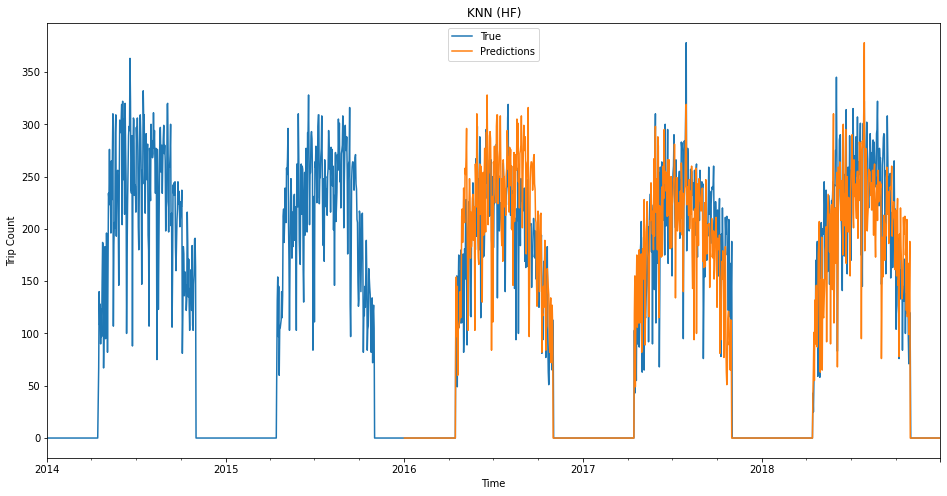

In [17]:
# Get CV results
results = cv_predict(None, demand_train, seasonal_period, training_function=cv_predictor)
predictions = utils.merge_cv_predictions(results)

plot_and_evaluate(demand_train, predictions, title='KNN (HF)');

# Save score
validation_scores['KNN'] = evaluate(demand_train, predictions)

### Test Performance

Error metrics for KNN (Test):

RMSE: 47.0242
MAE: 28.3205


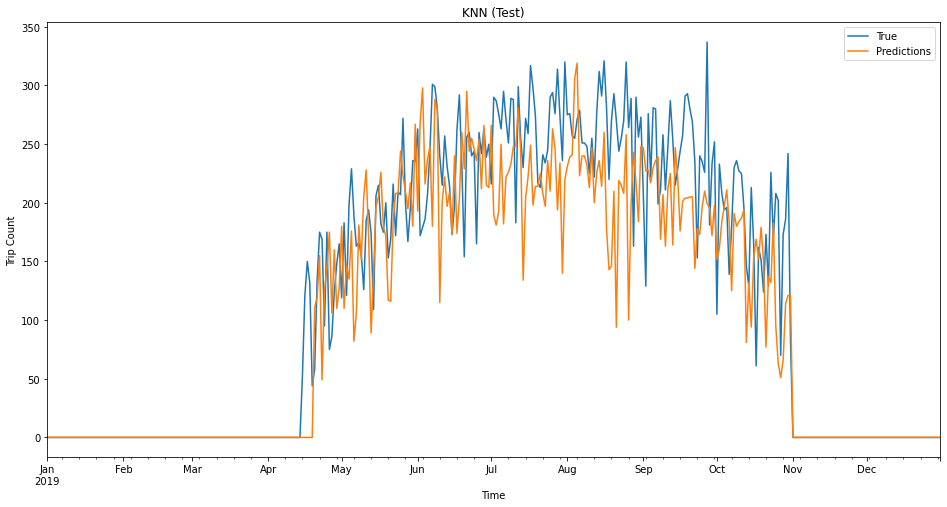

In [18]:
# Train test model
knn = KNeighborsRegressor(n_neighbors=1)
forecaster = make_reduction(estimator=knn, window_length=seasonal_period, strategy="recursive")
forecaster.fit(demand_train)

# Get predictions
predictions = forecaster.predict(test_fh)
plot_and_evaluate(demand_test, predictions, title='KNN (Test)');

# Save score
test_scores['KNN'] = evaluate(demand_test, predictions)

# Seasonal ARIMA

Required imports:

In [19]:
import gc

from sktime.forecasting.arima import AutoARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [20]:
# SARIMA model parameters
order = (0, 0, 0)
seasonal_order = (1, 0, 0, 365)

### Cross Validation

Our SARIMA models tend to be quite memory heavy, taking up over 24Gb of RAM on the full dataset.

In light of that, we make cross-validation cell execution optional and supply a special training function that makes sure to free up the memory after each iteration to avoid Out Of Memory errors.

In [21]:
# Flag determining wether to run SARIMA CV cells
RUN_CV = False

# Helper function to let our cross validation know
# how to create, fit and use the model to obtain predictions
def cv_predictor(train_data, val_data):
    # We need at least two years of training data to make a prediction
    if len(train_data) <= len(val_data):
        return None
    
    # Create the model
    model = SARIMAX(train_data, order=order, seasonal_order=seasonal_order)
    model = model.fit()
    
    # Get validation cutoff date
    val_cutoff = val_data.tail(1)
    
    # Get predictions until the cutoff
    predictions = model.forecast(val_cutoff.index.to_pydatetime()[0]).to_frame(name='trip_count')
    
    # Free up the memory
    del model
    gc.collect()
    
    return predictions

In [22]:
# Perform cross validation if it is enabled
if RUN_CV:
    cv_results = cv_predict(None, demand_train, seasonal_period, training_function=cv_predictor)

Error metrics for SARIMA (HF):

RMSE: 42.0708
MAE: 24.4986


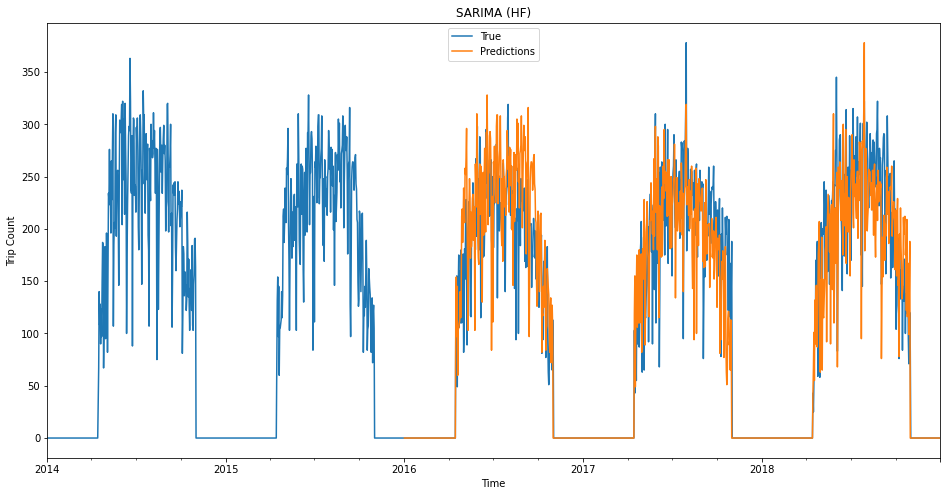

In [23]:
# If cv_results are defined, display plot and metrics
if 'cv_results' in locals():
    predictions = utils.merge_cv_predictions(results)
    plot_and_evaluate(demand_train, predictions, title='SARIMA (HF)');
    
    # Save score
    validation_scores['SARIMA'] = evaluate(demand_train, predictions)
else:
    print("No CV results available")

### Test Performance

In [24]:
# Define the model
model = SARIMAX(demand_train, order=order, seasonal_order=seasonal_order)

In [25]:
# Fit the model
# Takes a little while
model = model.fit()

In [26]:
# Display summary about the fitted model
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                 
=================================================================================
Dep. Variable:                trip_count   No. Observations:                 1826
Model:             SARIMAX(1, 0, 0, 365)   Log Likelihood               -9979.274
Date:                   Sat, 11 Dec 2021   AIC                          19962.549
Time:                           21:20:32   BIC                          19973.568
Sample:                       01-01-2014   HQIC                         19966.614
                            - 12-31-2018                                         
Covariance Type:                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L365      0.9644      0.003    349.925      0.000       0.959       0.970
sigma2      1921.2053     44.789     42.894      0.000    1833.420    2008.991
===================================================================================
Ljung-Box (L1) (Q):                 246.48   Jarque-Bera (JB):               416.69
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.10   Skew:                            -0.04
Prob(H) (two-sided):                  0.26   Kurtosis:                         5.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [27]:
# Get predictions
predictions = model.forecast('2019-12-31').to_frame(name='trip_count')

# Clean up the model and free memory
del model
gc.collect();

Error metrics for SARIMA (test):

RMSE: 41.7983
MAE: 24.3760


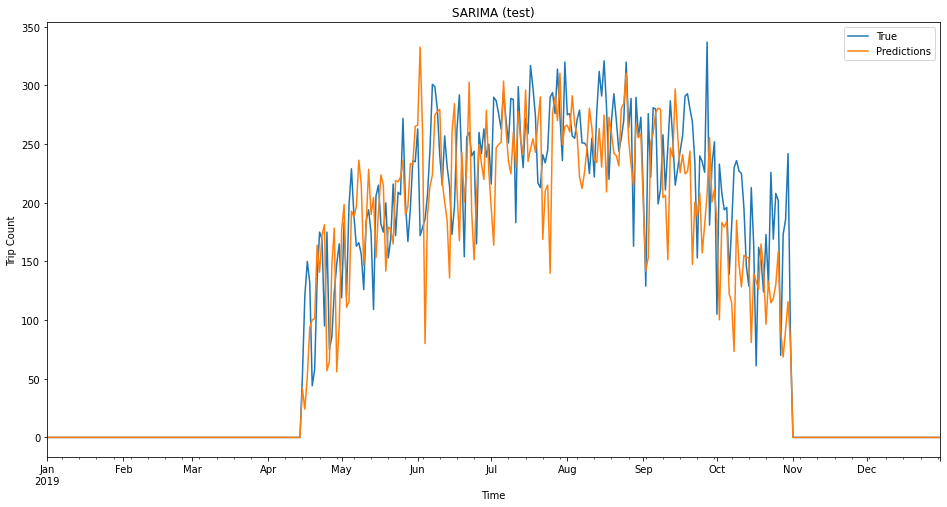

In [28]:
# Display test metrics
plot_and_evaluate(demand_test, predictions, title='SARIMA (test)');

# Save score
test_scores['SARIMA'] = evaluate(demand_test, predictions)

# Random Forests

Required imports:

In [29]:
import sklearn.ensemble

from lib import forest_utils

## Data Preparation

For Random Forests, we want to use the time data for each day such as year, month and day to make a bike demand prediction.

To obtain these input features, we define a helper function:

In [30]:
def create_features_and_labels(demand_data, weather_data=None):    
    # Split dates into day/month/year columns
    years = np.array(demand_data.index.year)
    months = np.array(demand_data.index.month)
    days = np.array(demand_data.index.day)
    
    # Form feature and target vectors
    features = np.column_stack((years,months,days))
    labels = np.array(demand_data['trip_count'])
    
    # If weather data is provided, append it to features
    if weather_data is not None:
        weather_np = weather_data.to_numpy()
        features = np.column_stack((features, weather_np))
        
    return (features, labels)

## Basic Model

First, we will use Random Forests with just the time features and see how they perform.

In [31]:
# Generate train and test features and labels
X_train_raw, y_train_raw = create_features_and_labels(demand_train)
X_test_raw, y_test_raw   = create_features_and_labels(demand_test)

### Cross Validation and Hyperparameter Search

To find the best model, we will perform a manual hyperparameter search on the number of trees in the forest and maximum tree depth.

In [32]:
# Set random seed for reproducibility
np.random.seed(1)

# Define Hyperparameters to search over
n_trials = 25
num_trees = np.random.randint(1,1000,size = n_trials)
depths = np.random.randint(1,11,size = n_trials)

print("Number of Trees: ", num_trees)
print("Maximum Tree Depths: ", depths)

Number of Trees:  [ 38 236 909  73 768 906 716 646 848 961 145 130 973 584 750 509 391 282
 179 277 255 358 915 469 908]
Maximum Tree Depths:  [ 3  5  8  8 10  2  8  1  7 10 10  8  7 10  2  1  2  9  9  4 10  9  8  4
  7]


In [33]:
# Perform cross validation on every model configuration
MSQ_by_trial, MAE_by_trial = forest_utils.forest_param_search(X_train_raw, y_train_raw, n_trials, num_trees, depths)

Testing model 1 of 25 num_trees: 38  and max_depth:  3
Testing model 2 of 25 num_trees: 236  and max_depth:  5
Testing model 3 of 25 num_trees: 909  and max_depth:  8
Testing model 4 of 25 num_trees: 73  and max_depth:  8
Testing model 5 of 25 num_trees: 768  and max_depth:  10
Testing model 6 of 25 num_trees: 906  and max_depth:  2
Testing model 7 of 25 num_trees: 716  and max_depth:  8
Testing model 8 of 25 num_trees: 646  and max_depth:  1
Testing model 9 of 25 num_trees: 848  and max_depth:  7
Testing model 10 of 25 num_trees: 961  and max_depth:  10
Testing model 11 of 25 num_trees: 145  and max_depth:  10
Testing model 12 of 25 num_trees: 130  and max_depth:  8
Testing model 13 of 25 num_trees: 973  and max_depth:  7
Testing model 14 of 25 num_trees: 584  and max_depth:  10
Testing model 15 of 25 num_trees: 750  and max_depth:  2
Testing model 16 of 25 num_trees: 509  and max_depth:  1
Testing model 17 of 25 num_trees: 391  and max_depth:  2
Testing model 18 of 25 num_trees: 282 

Best Classifier Attributes
Number of Estimators:  768 Max Depth:  10
MSE of best classifer:  1071.2793634776347
MAE of best classifier:  20.246777784998464


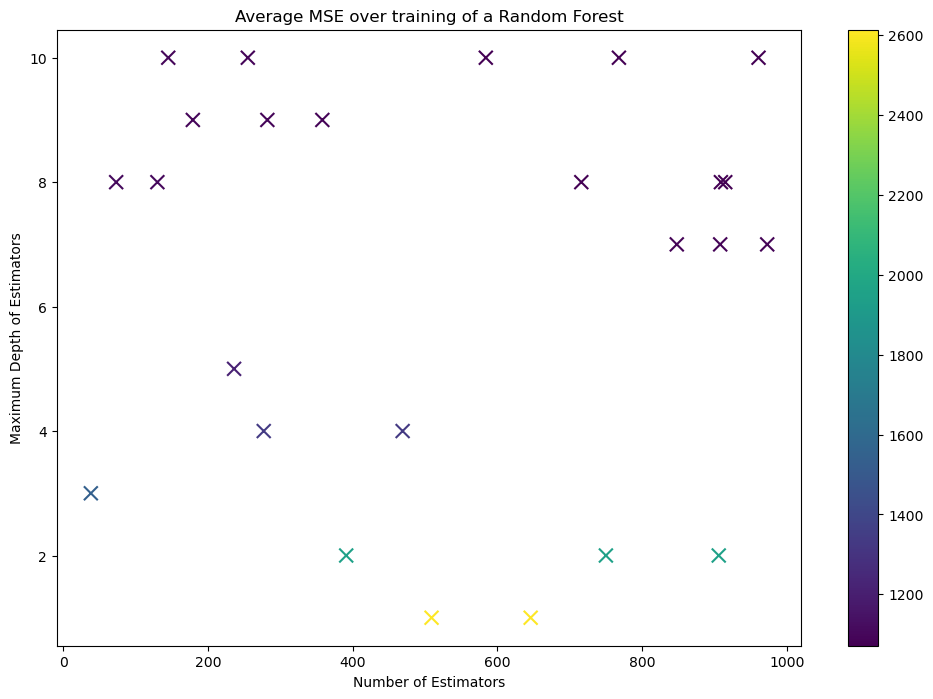

In [75]:
# Plot a summary of hyperparameter effects on MSE
forest_utils.plot_param_performance(num_trees, depths, MSQ_by_trial, MAE_by_trial)

# Save score
validation_scores['forest'] = (np.sqrt(MSQ_by_trial[np.argmin(MSQ_by_trial)]), MAE_by_trial[np.argmin(MAE_by_trial)])

### Best Model Test Performance

In [38]:
# Define and fit the best performing model
model = sklearn.ensemble.RandomForestRegressor(n_estimators= num_trees[np.argmin(MSQ_by_trial)], 
                                               max_depth = depths[np.argmin(MSQ_by_trial)], 
                                               random_state=0)

# Train model on all data from 2014 to 2018
model = model.fit(X_train_raw,y_train_raw)

Error metrics for Random Forests (Test):

RMSE: 32.8384
MAE: 20.0511


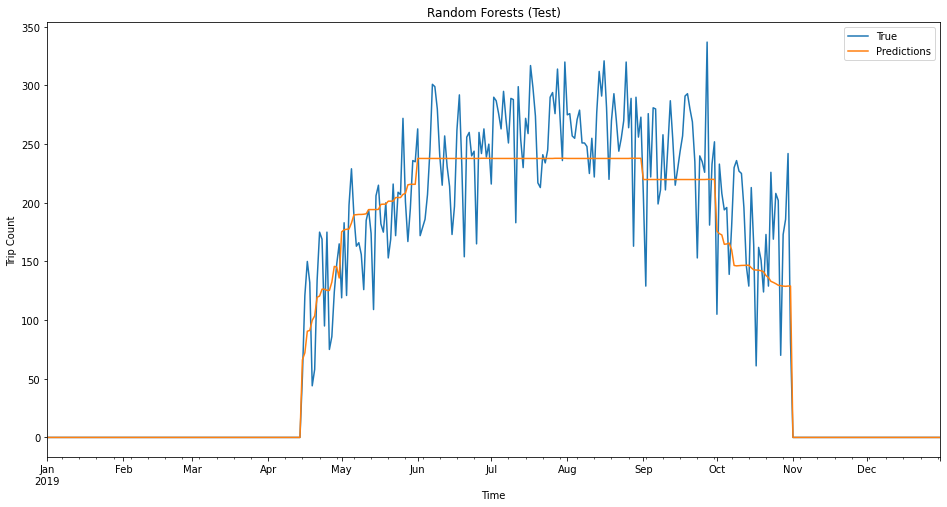

In [39]:
# Make and evaluate predictions
y_final_pred = model.predict(X_test_raw)
predictions = pd.DataFrame(y_final_pred, index=demand_test.index, columns=['trip_count'])

plot_and_evaluate(demand_test, predictions, title='Random Forests (Test)');

# Save score
test_scores['forest'] = evaluate(demand_test, predictions)

## Weather Model

We will now add weather features to our model and evaluate how much it affects model performance.

In [40]:
# Load weather data
weather_data = pd.read_csv('data/weather.csv', index_col='Date/Time', parse_dates=['Date/Time'])

In [41]:
# Split the weather data into training and test sets similarly to demand data
weather_train = weather_data['2014':'2018']
weather_test  = weather_data['2019':'2019']

# Generate train and test features and labels
X_train_wxr, y_train_wxr = create_features_and_labels(demand_train, weather_train)
X_test_wxr, y_test_wxr = create_features_and_labels(demand_test, weather_test)

### Cross Validation and Hyperparameter Search

To find the best model, we will perform a manual hyperparameter search on the number of trees in the forest and maximum tree depth.

In [42]:
# Set random seed for reproducibility
np.random.seed(1)

# Define Hyperparameters to search over
n_trials = 25
num_trees = np.random.randint(1,1000,size = n_trials)
depths = np.random.randint(1,11,size = n_trials)

print("Number of Trees: ", num_trees)
print("Maximum Tree Depths: ", depths)

Number of Trees:  [ 38 236 909  73 768 906 716 646 848 961 145 130 973 584 750 509 391 282
 179 277 255 358 915 469 908]
Maximum Tree Depths:  [ 3  5  8  8 10  2  8  1  7 10 10  8  7 10  2  1  2  9  9  4 10  9  8  4
  7]


In [43]:
# Perform cross validation on every model configuration
MSQ_by_trial, MAE_by_trial = forest_utils.forest_param_search(X_train_wxr, y_train_wxr, n_trials, num_trees, depths)

Testing model 1 of 25 num_trees: 38  and max_depth:  3
Testing model 2 of 25 num_trees: 236  and max_depth:  5
Testing model 3 of 25 num_trees: 909  and max_depth:  8
Testing model 4 of 25 num_trees: 73  and max_depth:  8
Testing model 5 of 25 num_trees: 768  and max_depth:  10
Testing model 6 of 25 num_trees: 906  and max_depth:  2
Testing model 7 of 25 num_trees: 716  and max_depth:  8
Testing model 8 of 25 num_trees: 646  and max_depth:  1
Testing model 9 of 25 num_trees: 848  and max_depth:  7
Testing model 10 of 25 num_trees: 961  and max_depth:  10
Testing model 11 of 25 num_trees: 145  and max_depth:  10
Testing model 12 of 25 num_trees: 130  and max_depth:  8
Testing model 13 of 25 num_trees: 973  and max_depth:  7
Testing model 14 of 25 num_trees: 584  and max_depth:  10
Testing model 15 of 25 num_trees: 750  and max_depth:  2
Testing model 16 of 25 num_trees: 509  and max_depth:  1
Testing model 17 of 25 num_trees: 391  and max_depth:  2
Testing model 18 of 25 num_trees: 282 

Best Classifier Attributes
Number of Estimators:  768 Max Depth:  10
MSE of best classifer:  1071.2793634776347
MAE of best classifier:  20.246777784998464


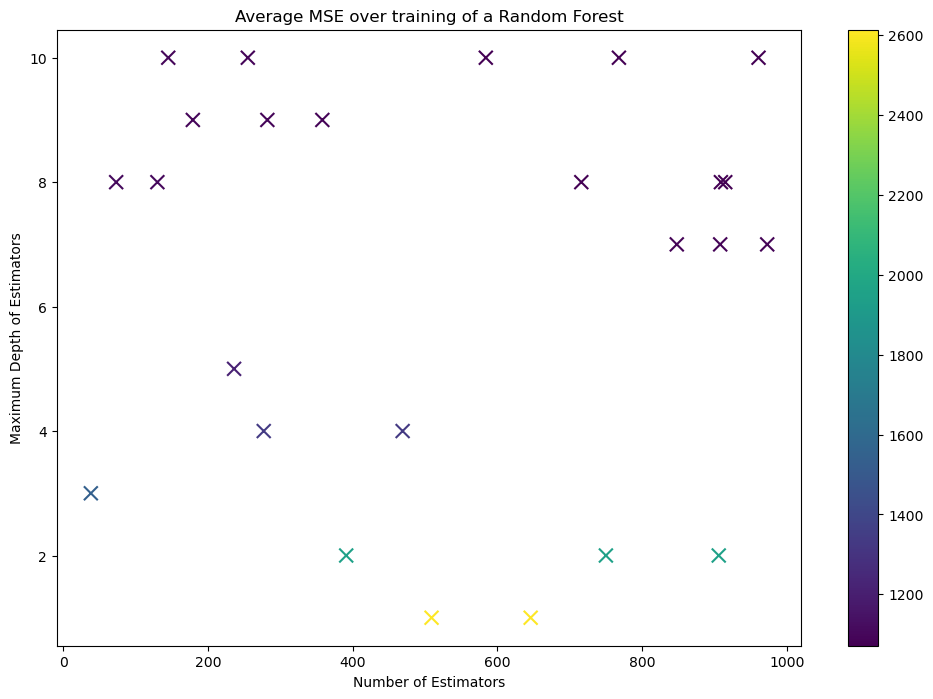

In [76]:
# Plot a summary of hyperparameter effects on MSE
forest_utils.plot_param_performance(num_trees, depths, MSQ_by_trial, MAE_by_trial)

# Save score
validation_scores['forest_weather'] = (np.sqrt(MSQ_by_trial[np.argmin(MSQ_by_trial)]), MAE_by_trial[np.argmin(MAE_by_trial)])

### Best Model Test Performance

In [45]:
# Define and fit the best performing model
model = sklearn.ensemble.RandomForestRegressor(n_estimators= num_trees[np.argmin(MSQ_by_trial)], 
                                               max_depth = depths[np.argmin(MSQ_by_trial)], 
                                               random_state=0)

# Train model on all data from 2014 to 2018
model = model.fit(X_train_wxr, y_train_wxr)

Error metrics for Random Forests with Weather (Test):

RMSE: 27.1922
MAE: 15.5966


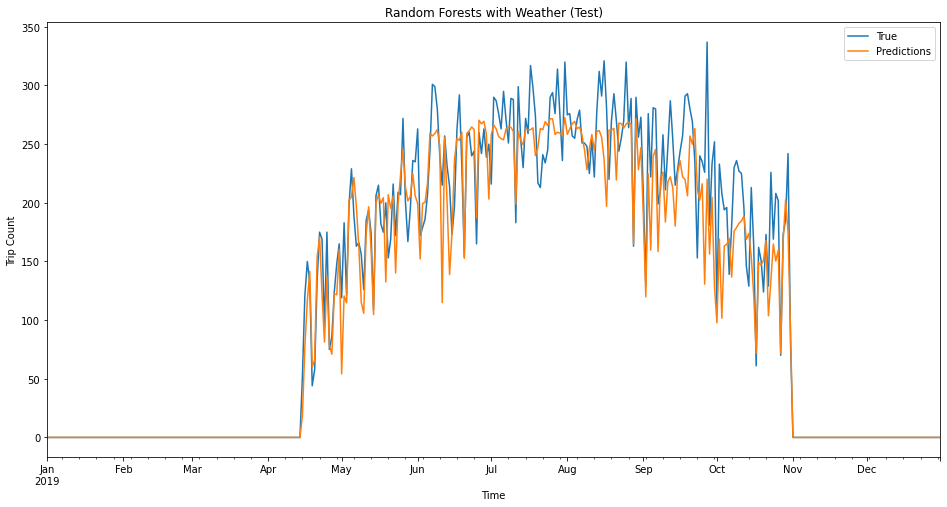

In [46]:
# Make and evaluate predictions
y_final_pred = model.predict(X_test_wxr)
predictions = pd.DataFrame(y_final_pred, index=demand_test.index, columns=['trip_count'])

plot_and_evaluate(demand_test, predictions, title='Random Forests with Weather (Test)');

# Save score
test_scores['forest_weather'] = evaluate(demand_test, predictions)

# LSTM

A GPU is recommended for fitting LSTM models.

Due to the framework requirements, for the LSTM model we use the following data split:
    
* Train - 2014-2017. The training happens using a sliding time-window, leading to a total of 3 splits, where the first year is used as input and the second year as the output.
* Validation - 2017-2018. One year is withheld for validation during training in order to find the optimal number of epochs before we start overfitting. Validation makes a prediction on 2018 demand using 2017 data.
* Test - 2018-2019. This is the test set used for measuring performance of the best models.

Performance evaluation using historical forecasts (backtesting) are still provided as usual.

Required imports:

In [47]:
import darts.dataprocessing
import darts.models
import darts.metrics

from darts.utils.timeseries_generation import datetime_attribute_timeseries

from lib import lstm_utils

# Revert darts changes to matplotlib style
import matplotlib as mpl
mpl.style.use('default')

## Data Preparation

First, we convert our time-series dataframe into a *darts* time series and split it.

In [48]:
# Convert into a darts TimeSeries
series = darts.TimeSeries.from_dataframe(station_bike_demand)

# Split into training, validation and test sets
train_full_series, test_series = series.split_after(pd.to_datetime('2018-12-31'))
_, val_series = train_full_series.split_after(pd.to_datetime('2016-12-31'))
train_series, _ = train_full_series.split_after(pd.to_datetime('2017-12-31'))

Second, we normalize the feature for LSM input using a min-max scaler.

In [49]:
# Normalize the dataset using a min-max scaler
transformer = darts.dataprocessing.transformers.Scaler()

# Fit the scaler
train_transformed = transformer.fit_transform(train_series)

# Use the scaler to transform all splits
val_transformed = transformer.transform(val_series)
train_full_transformed = transformer.transform(train_full_series)
test_transformed = transformer.transform(test_series)

series_transformed = transformer.transform(series)

Finally, we create covariate time-series based on day, month and year to be used as additional features for training and prediction.

In [50]:
# Create and scale year covariates
year_series = datetime_attribute_timeseries(station_bike_demand.index, attribute='year', one_hot=False)
year_series = darts.dataprocessing.transformers.Scaler().fit_transform(year_series)

# Create month and day of the week covariates using a one-hot encoding
month_series = datetime_attribute_timeseries(year_series, attribute='month', one_hot=True)
day_series = datetime_attribute_timeseries(year_series, attribute='weekday', one_hot=True)

# Stack covariates together into a joint time-series
covariates = year_series.stack(month_series).stack(day_series)

## Basic Model

First, we will train an LSTM model using only the demand history and time-based covariates.

The hyperparameters used for training were found to be the optimal out of the ones considered using grid search. The code for grid search is given at the end of the LSTM sections, as it takes relatively long to run even with a GPU. 

In [51]:
# Define optimal parameters
n_dims = 20
n_layers = 3
dropout = 0.2

max_epochs = 50

In [52]:
# Define the model
lstm_model = darts.models.RNNModel(
    model='LSTM',
    hidden_dim=n_dims,
    n_rnn_layers=n_layers,
    dropout=dropout,
    optimizer_kwargs={'lr': 1e-3},
    n_epochs=max_epochs,
    batch_size=16,        
    training_length=seasonal_period,
    input_chunk_length=seasonal_period,
    model_name='basic_LSTM',
    force_reset=True,
    save_checkpoints=True,
    random_state=0
)

In [53]:
# Train the model and get the iteration that performs best on the validation set
lstm_model.fit(train_transformed,
             future_covariates=covariates,
             val_series=val_transformed,
             val_future_covariates=covariates,
             verbose=True)

[2021-12-11 21:25:58,013] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1096 samples.
[2021-12-11 21:25:58,013] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1096 samples.
INFO:darts.models.forecasting.torch_forecasting_model:Train dataset contains 1096 samples.
[2021-12-11 21:25:58,023] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2021-12-11 21:25:58,023] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
INFO:darts.models.forecasting.torch_forecasting_model:Time series values are 64-bits; casting model to float64.


  0%|          | 0/50 [00:00<?, ?it/s]

In [54]:
# Load the model with the lowest validation loss
lstm_model = darts.models.RNNModel.load_from_checkpoint(model_name='basic_LSTM', best=True)

[2021-12-11 21:32:40,370] INFO | darts.models.forecasting.torch_forecasting_model | loading model_best_40.pth.tar
[2021-12-11 21:32:40,370] INFO | darts.models.forecasting.torch_forecasting_model | loading model_best_40.pth.tar
INFO:darts.models.forecasting.torch_forecasting_model:loading model_best_40.pth.tar


### Cross-validation Performance

In [55]:
# Perform historical forecast CV
prediction_series = lstm_utils.cv_predict(lstm_model, train_full_transformed, covariates)

  0%|          | 0/1097 [00:00<?, ?it/s]

Error metrics for LSTM (HF):

RMSE: 27.0834
MAE: 15.0380


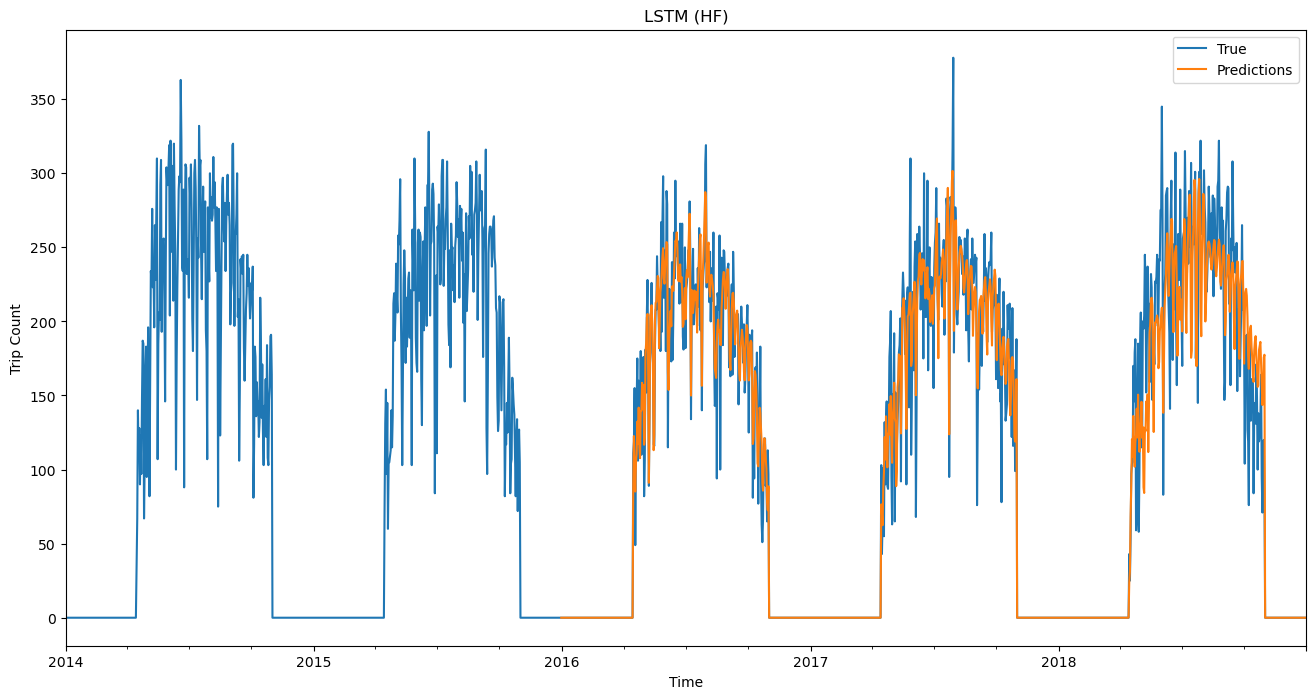

In [56]:
prediction_series_rescaled = transformer.inverse_transform(prediction_series)

predictions = prediction_series_rescaled.pd_dataframe()
predictions.rename(columns={'0':'trip_count'}, inplace=True)

plot_and_evaluate(demand_train, predictions, title='LSTM (HF)');

# Save score
validation_scores['LSTM'] = evaluate(demand_train, predictions)

### Test Performance

To evaluate test performance, we retrain the model with best parameters on the full training set and evaluate its predictions with respect to the test set.

In [57]:
# Get the untrained model and retrain on full data using the optimal number of epochs
lstm_model = lstm_model.untrained_model()

lstm_model.fit(train_full_transformed,
             future_covariates=covariates,
             epochs = 40,
             verbose=True)

[2021-12-11 21:35:14,447] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1461 samples.
[2021-12-11 21:35:14,447] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1461 samples.
INFO:darts.models.forecasting.torch_forecasting_model:Train dataset contains 1461 samples.
[2021-12-11 21:35:14,450] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2021-12-11 21:35:14,450] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
INFO:darts.models.forecasting.torch_forecasting_model:Time series values are 64-bits; casting model to float64.


  0%|          | 0/40 [00:00<?, ?it/s]

Error metrics for LSTM (Test):

RMSE: 35.8533
MAE: 20.9371


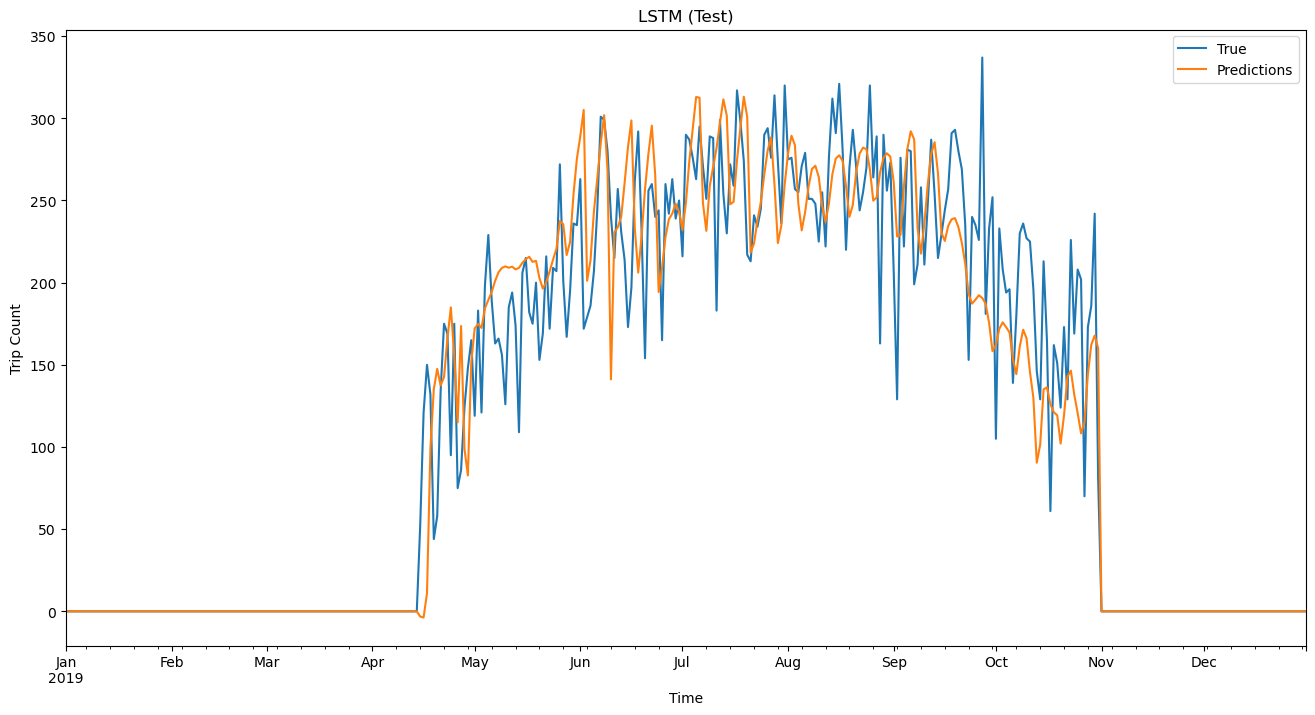

In [58]:
prediction_series = lstm_model.predict(series=train_full_transformed, n=seasonal_period, future_covariates=covariates)
prediction_series_rescaled = transformer.inverse_transform(prediction_series)

predictions = prediction_series_rescaled.pd_dataframe()
predictions.rename(columns={'0':'trip_count'}, inplace=True)

plot_and_evaluate(demand_test, predictions, title='LSTM (Test)');

# Save score
test_scores['LSTM'] = evaluate(demand_test, predictions)

## Weather Model

We will now add weather features to our model and evaluate how much it affects model performance.

In [59]:
# Load weather data, normalize it and add to covariates
weather_df = pd.read_csv('data/weather.csv', index_col='Date/Time', parse_dates=['Date/Time'])

weather_series = darts.TimeSeries.from_dataframe(weather_df)
weather_series = darts.dataprocessing.transformers.Scaler().fit_transform(weather_series)

weather_covariates = covariates.stack(weather_series)

In [60]:
# Define optimal parameters for weather model
n_dims = 10
n_layers = 2
dropout = 0.2

max_epochs = 50

In [61]:
# Define the model
weather_lstm_model = darts.models.RNNModel(
    model='LSTM',
    hidden_dim=n_dims,
    dropout=dropout,
    n_rnn_layers=n_layers,
    optimizer_kwargs={'lr': 1e-3},
    n_epochs=max_epochs,
    batch_size=16,
    training_length=seasonal_period,
    input_chunk_length=seasonal_period, 
    model_name='weather_LSTM',  
    force_reset=True,
    save_checkpoints=True,
    random_state=0
)

In [62]:
# Train the model and get the iteration that performs best on the validation set
weather_lstm_model.fit(train_transformed,
             future_covariates=weather_covariates,
             val_series=val_transformed,
             val_future_covariates=weather_covariates,
             verbose=True)

[2021-12-11 21:41:40,600] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1096 samples.
[2021-12-11 21:41:40,600] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1096 samples.
INFO:darts.models.forecasting.torch_forecasting_model:Train dataset contains 1096 samples.
[2021-12-11 21:41:40,603] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2021-12-11 21:41:40,603] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
INFO:darts.models.forecasting.torch_forecasting_model:Time series values are 64-bits; casting model to float64.


  0%|          | 0/50 [00:00<?, ?it/s]

In [63]:
# Load the model with the lowest validation loss
weather_lstm_model = darts.models.RNNModel.load_from_checkpoint(model_name='weather_LSTM', best=True)

[2021-12-11 21:44:55,436] INFO | darts.models.forecasting.torch_forecasting_model | loading model_best_20.pth.tar
[2021-12-11 21:44:55,436] INFO | darts.models.forecasting.torch_forecasting_model | loading model_best_20.pth.tar
INFO:darts.models.forecasting.torch_forecasting_model:loading model_best_20.pth.tar


### Cross-validation Performance

In [64]:
# Perform historical forecast CV
prediction_series = lstm_utils.cv_predict(weather_lstm_model, train_full_transformed, weather_covariates)

  0%|          | 0/1097 [00:00<?, ?it/s]

Error metrics for LSTM Weather (HF):

RMSE: 25.4553
MAE: 14.4597


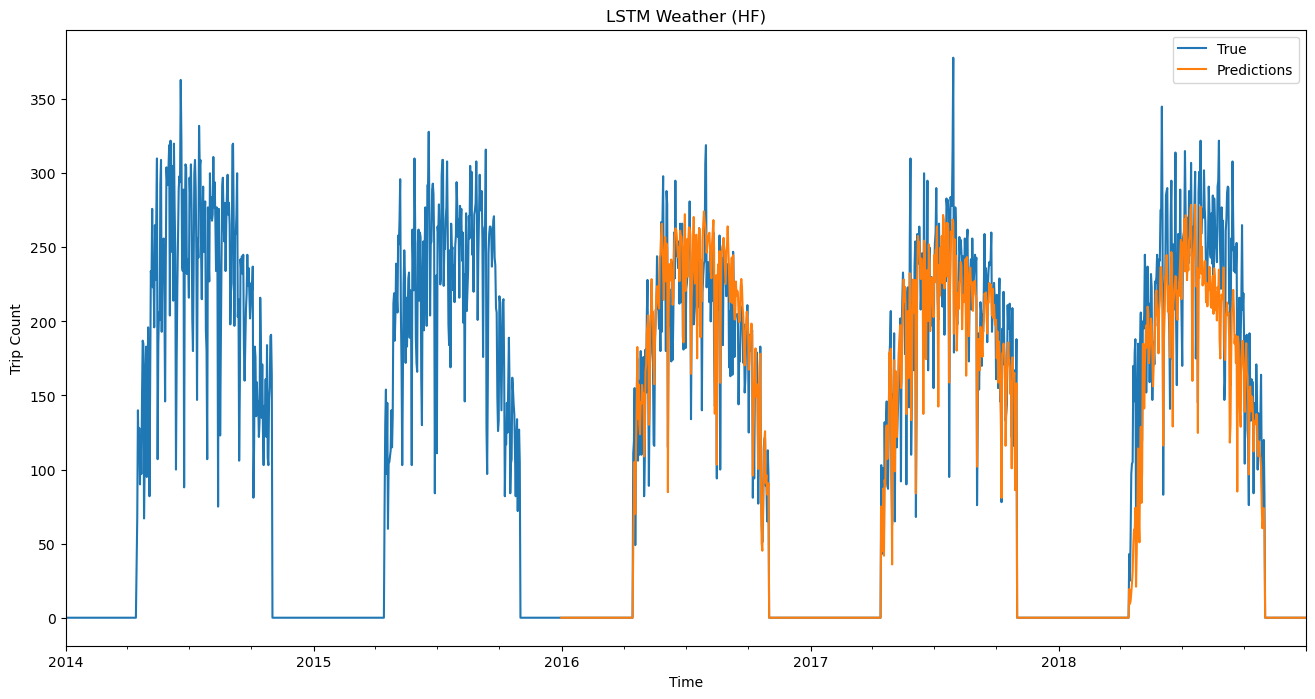

In [67]:
prediction_series_rescaled = transformer.inverse_transform(prediction_series)

predictions = prediction_series_rescaled.pd_dataframe()
predictions.rename(columns={'0':'trip_count'}, inplace=True)


plot_and_evaluate(demand_train, predictions, title='LSTM Weather (HF)');

# Save score
validation_scores['LSTM_weather'] = evaluate(demand_train, predictions)

### Test Performance

To evaluate test performance, we retrain the model with best parameters on the full training set and evaluate its predictions with respect to the test set.

In [68]:
# Get the untrained model and retrain on full data using the optimal number of epochs
weather_lstm_model = weather_lstm_model.untrained_model()

weather_lstm_model.fit(train_full_transformed,
             future_covariates=weather_covariates,
             epochs = 20,
             verbose=True)

[2021-12-11 21:48:05,593] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1461 samples.
[2021-12-11 21:48:05,593] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1461 samples.
INFO:darts.models.forecasting.torch_forecasting_model:Train dataset contains 1461 samples.
[2021-12-11 21:48:05,596] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2021-12-11 21:48:05,596] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
INFO:darts.models.forecasting.torch_forecasting_model:Time series values are 64-bits; casting model to float64.


  0%|          | 0/20 [00:00<?, ?it/s]

Error metrics for LSTM Weather (Test):

RMSE: 29.0169
MAE: 17.0623


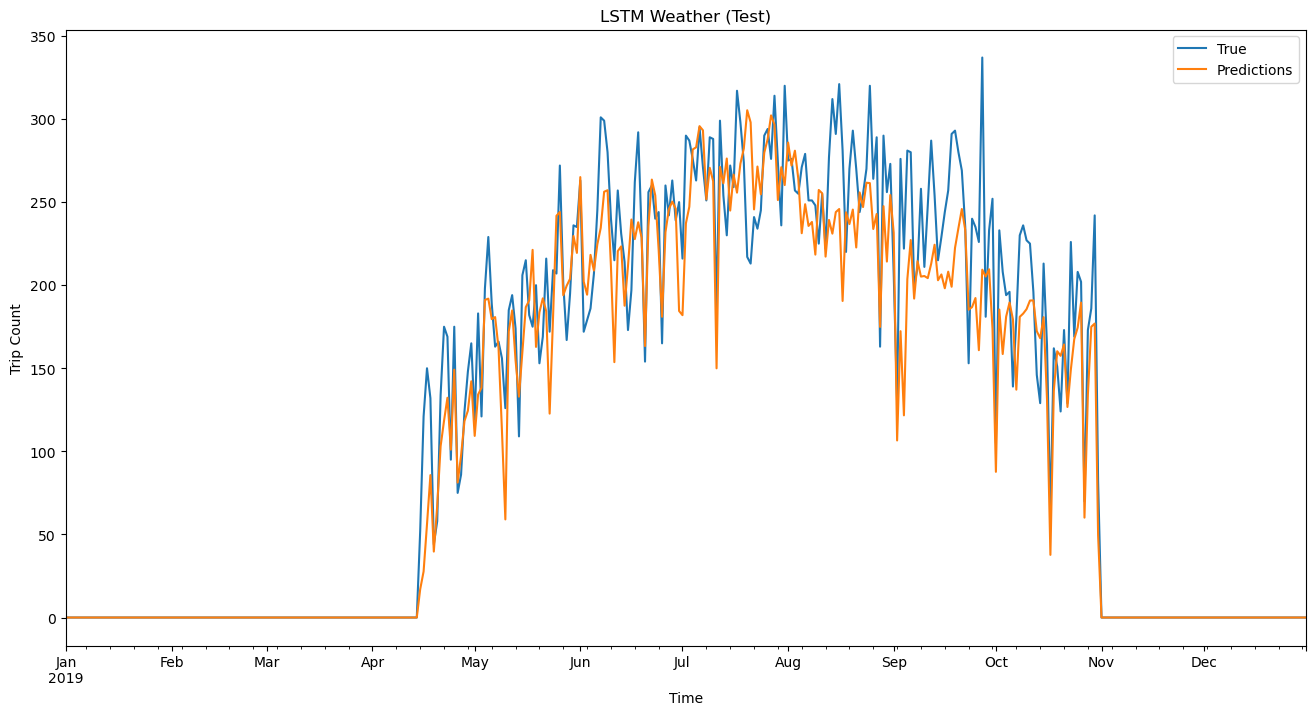

In [69]:
prediction_series = weather_lstm_model.predict(series=train_full_transformed, n=seasonal_period, future_covariates=weather_covariates)
prediction_series_rescaled = transformer.inverse_transform(prediction_series)

predictions = prediction_series_rescaled.pd_dataframe()
predictions.rename(columns={'0':'trip_count'}, inplace=True)

plot_and_evaluate(demand_test, predictions, title='LSTM Weather (Test)');

# Save score
test_scores['LSTM_weather'] = evaluate(demand_test, predictions)

# Grid Search

Following is the grid search code used to find optimal hyperparameters for LSTM models. Running it takes over an over with a GPU, as such its execution is optional.

In [70]:
# Define search params
params = {'hidden_dim':[10,20,30], 'n_rnn_layers':[1,2,3], 'dropout':[0, 0.1, 0.2]}

In [71]:
RUN_CELL = False

if RUN_CELL:
    #Run search
    best_model = darts.models.RNNModel.gridsearch(parameters=params, 
                                     series=train_full_transformed,
                                     start=train_full_transformed.start_time()+pd.DateOffset(years=1),
                                     future_covariates=covariates,
                                     forecast_horizon=seasonal_period,
                                     stride=seasonal_period,
                                     verbose=True,
                                     metric=darts.metrics.mse)   
    
    # Print best model params
    print(best_model)

In [72]:
RUN_CELL = False

if RUN_CELL:
    #Run search
    best_weather_model = darts.models.RNNModel.gridsearch(parameters=params, 
                                 series=train_full_transformed,
                                 start=train_full_transformed.start_time()+pd.DateOffset(years=1),
                                 future_covariates=weather_covariates,
                                 forecast_horizon=seasonal_period,
                                 stride=seasonal_period,
                                 verbose=True,
                                 metric=darts.metrics.mse) 
    
    # Print best model params
    print(best_weather_model)

# Result Summary

The scores of each models for historical forecasts validation and test performance are summarized in this section.

In [90]:
# Create and show validation table
validation_results = pd.DataFrame.from_dict(validation_scores, orient='index', columns=['RMSE', 'MAE']).sort_values(by=['RMSE'])
print('Validation scores:')
display(validation_results)

# Create test table
test_results = pd.DataFrame.from_dict(test_scores, orient='index', columns=['RMSE', 'MAE']).sort_values(by=['RMSE'])
print('Test scores:')
display(test_results)

Validation scores:


,RMSE,MAE
LSTM_weather,25.455276,14.459729
LSTM,27.083381,15.038036
forest,32.730404,20.246778
forest_weather,32.730404,20.246778
prophet,33.814793,18.972101
naive,40.826668,23.460331
KNN,42.070847,24.498630
SARIMA,42.070847,24.498630


Test scores:


,RMSE,MAE
forest_weather,27.192158,15.596557
LSTM_weather,29.016939,17.062310
prophet,31.224228,18.234823
forest,32.838420,20.051081
LSTM,35.853257,20.937108
naive,37.049742,22.252055
SARIMA,41.798298,24.376011
KNN,47.024243,28.320548


# Appendix: Forecasting at Weekly/Monthly Frequencies

In this section we will test how well some of the models perform when producing weekly and monthly forecasts, as opposed to daily forecasts that we've been doing so far.

In particular, we will consider the AutoARIMA, KNN, and Prophet models.

Required imports:

In [80]:
from sklearn.neighbors import KNeighborsRegressor
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.fbprophet import Prophet
from sktime.forecasting.compose import make_reduction

from sktime.utils.plotting import plot_series
from sktime.performance_metrics.forecasting import MeanSquaredError, MeanAbsoluteError

## Weekly Forecast Performance

In [81]:
# Load data at a weekly frequency
y_weekly = station_bike_demand.asfreq('W')

yw_train = y_weekly['2014':'2018']
yw_test  = y_weekly['2019':'2019']

# Setup the forecasting horizon
fh = np.arange(1, len(yw_test)+1)

In [82]:
# Define forecasters and run training
forecasters = dict()
forecasters['auto_arima'] = AutoARIMA(sp=1, suppress_warnings=True)
forecasters['knn'] = make_reduction(estimator=KNeighborsRegressor(n_neighbors=1), window_length=52, strategy="recursive")
forecasters['prophet'] =  Prophet(
                            seasonality_mode='additive',
                            n_changepoints=25, # default
                            add_country_holidays={'country_name': 'Canada'},
                            daily_seasonality=False,
                            weekly_seasonality=True,
                            yearly_seasonality=True)

results = dict()
results["y_test"] = yw_test['2019-04':'2019-10']
for key, forecaster in forecasters.items():
    if key == 'prophet':
        forecaster.fit(yw_train['trip_count'])
    else:
        forecaster.fit(yw_train)
    results[key] = forecaster.predict(fh)
    results[key] = results[key]['2019-04':'2019-10'] #reduce fh to only the operating period

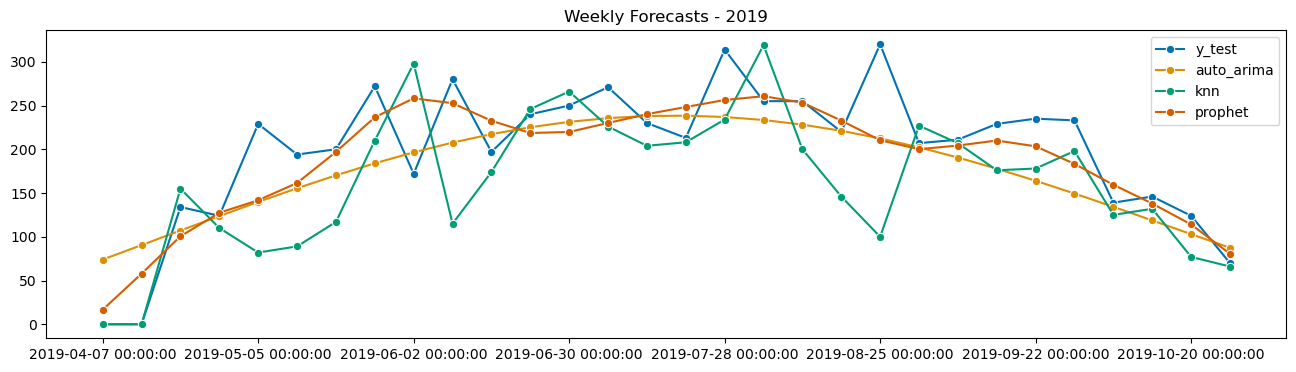

In [83]:
# Plot weekly predictions
x_ticks = [y.to_pydatetime().strftime("%m-%d") for y in yw_test.index]
plot_series(*list(results.values()), labels=list(results.keys()))
plt.title("Weekly Forecasts - 2019");

In [84]:
# Print error metrics for each model
for key, forecaster in forecasters.items():
    print(key)
    print('  MSE: ', MeanSquaredError(multioutput='uniform_average',square_root=True)(results['y_test'], results[key]))
    print('  MAE: ', MeanAbsoluteError(multioutput='uniform_average')(results['y_test'], results[key]))

auto_arima
  MSE:  50.50599092803406
  MAE:  39.73717439541675
knn
  MSE:  74.91439559034477
  MAE:  52.833333333333336
prophet
  MSE:  40.29084430614218
  MAE:  30.238651926226048


## Monthly Forecast Performance

In [85]:
# Load data at a monthly frequency
y_monthly = station_bike_demand.asfreq('M')

ym_train = y_monthly['2014':'2018']
ym_test  = y_monthly['2019':'2019']

# Setup the forecasting horizon
fh = np.arange(1, len(ym_test)+1)

In [86]:
# Define forecasters and run training
forecasters = dict()
forecasters['auto_arima'] = AutoARIMA(sp=12, suppress_warnings=True)
forecasters['knn'] = make_reduction(estimator=KNeighborsRegressor(n_neighbors=1), window_length=12, strategy="recursive")
forecasters['prophet'] =  Prophet(
                            seasonality_mode='additive',
                            n_changepoints=25, # default
                            add_country_holidays={'country_name': 'Canada'},
                            daily_seasonality=False,
                            weekly_seasonality=False,
                            yearly_seasonality=True)

results = dict()
results["y_test"] = ym_test['2019-04':'2019-10']
for key, forecaster in forecasters.items():
    if key == 'prophet':
        forecaster.fit(ym_train['trip_count'])
    else:
        forecaster.fit(ym_train)
    results[key] = forecaster.predict(fh)
    results[key] = results[key]['2019-04':'2019-10'] #reduce fh to only the operating period

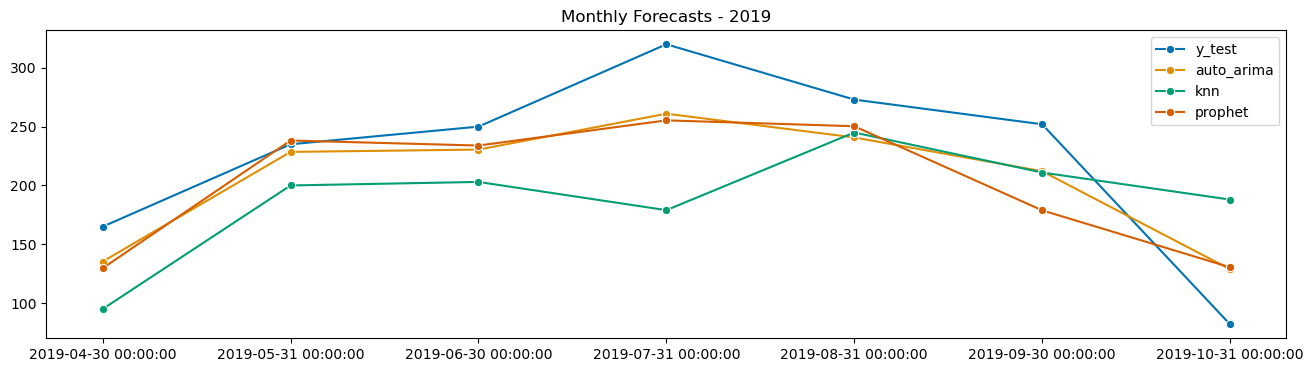

In [87]:
# Plot montly predictions
plot_series(*list(results.values()), labels=list(results.keys()))
plt.title("Monthly Forecasts - 2019");

In [88]:
# Print error metrics for each model
for key, forecaster in forecasters.items():
    print(key)
    print('  MSE: ', MeanSquaredError(multioutput='uniform_average',square_root=True)(results['y_test'], results[key]))
    print('  MAE: ', MeanAbsoluteError(multioutput='uniform_average')(results['y_test'], results[key]))

auto_arima
  MSE:  37.04139961992363
  MAE:  33.36685385387833
knn
  MSE:  77.38216848861241
  MAE:  66.85714285714286
prophet
  MSE:  44.57952489247924
  MAE:  37.648643134866404
